## Applied ML for baseball:

#### By Thomas Maxence Franco 
Submitted to the Faculty of Science in partial fulfillment of the requirements for the degree of 
#### Master of Modeling for Science and Engineering 
at the 
#### UNIVERSITAT AUTÒNOMA DE BARCELONA 
Directed by 
Tomás Manuel Margalef Burrull
July 2024


In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [2]:
file_path = "C:\\Users\\mfran\\OneDrive - UAB\\Masters\\Thesis\\Batting\\tables\\tradfinalbat.csv"
df = pd.read_csv(file_path)


In [3]:
df.head()

,Name,contract_years,salary,AAV,minor_league,catcher,date,new_team,former_team,Age,...,SB_2,BB%_2,K%_2,AVG_2,OBP_2,SLG_2,GDP_2,CS_2,H_2,OPS_2
0,Shohei Ohtani,10,700.0,70.000000,0,0,2024,LAD,LAA,29,...,11,0.108108,0.241742,0.273038,0.355856,0.518771,6,9,160,0.874627
1,Aaron Judge,9,360.0,40.000000,0,0,2023,NYY,NYY,31,...,6,0.118483,0.249605,0.287273,0.372828,0.543636,16,1,158,0.916464
2,Carlos Correa,3,105.3,35.100000,0,0,2022,MIN,HOU,27,...,1,0.109034,0.233645,0.278571,0.358255,0.567857,8,0,78,0.926113
3,Anthony Rendon,7,245.0,35.000000,0,0,2020,LAA,WSN,30,...,2,0.092127,0.137353,0.308129,0.373534,0.534972,5,1,163,0.908506
4,Carlos Correa,6,200.0,33.333333,0,0,2023,MIN,MIN,28,...,0,0.117188,0.181250,0.279279,0.365625,0.484685,16,0,155,0.850310


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 46 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              677 non-null    object 
 1   contract_years    677 non-null    int64  
 2   salary            677 non-null    float64
 3   AAV               677 non-null    float64
 4   minor_league      677 non-null    int64  
 5   catcher           677 non-null    int64  
 6   date              677 non-null    int64  
 7   new_team          677 non-null    object 
 8   former_team       677 non-null    object 
 9   Age               677 non-null    int64  
 10  WAR3              677 non-null    float64
 11  Yrs               677 non-null    int64  
 12  career_games      677 non-null    int64  
 13  stayed_same_team  677 non-null    int64  
 14  G                 677 non-null    int64  
 15  PA                677 non-null    int64  
 16  HR                677 non-null    int64  
 1

Null values where handled in a previous step manually. The small amount of null values was due to players not playing through a season because of injury, but that would damage both of the season as we need last season's data to fill the second to last. I had to find each player's stats in order to not lose any data. This can be handled differently to optimize time. 

In [5]:
df2 = df.rename(columns={'date':'year'})
df2.head()

,Name,contract_years,salary,AAV,minor_league,catcher,year,new_team,former_team,Age,...,SB_2,BB%_2,K%_2,AVG_2,OBP_2,SLG_2,GDP_2,CS_2,H_2,OPS_2
0,Shohei Ohtani,10,700.0,70.000000,0,0,2024,LAD,LAA,29,...,11,0.108108,0.241742,0.273038,0.355856,0.518771,6,9,160,0.874627
1,Aaron Judge,9,360.0,40.000000,0,0,2023,NYY,NYY,31,...,6,0.118483,0.249605,0.287273,0.372828,0.543636,16,1,158,0.916464
2,Carlos Correa,3,105.3,35.100000,0,0,2022,MIN,HOU,27,...,1,0.109034,0.233645,0.278571,0.358255,0.567857,8,0,78,0.926113
3,Anthony Rendon,7,245.0,35.000000,0,0,2020,LAA,WSN,30,...,2,0.092127,0.137353,0.308129,0.373534,0.534972,5,1,163,0.908506
4,Carlos Correa,6,200.0,33.333333,0,0,2023,MIN,MIN,28,...,0,0.117188,0.181250,0.279279,0.365625,0.484685,16,0,155,0.850310


#### The Shohei Ohtani case. 

The japanese superstar signed a record 700M-10year deal with the LA Dodgers this season (2024). The contract itself has very special characteristics that make it unique. First, he is the first player since Babe Ruth to play both pitcher and batter at an elite level. The Dodgers are essentially getting two players extremely talented players in one, except for this year that he won't be able to pitch as he is recovering from a UCL injury. The record AAV for a pitcher excluding Ohtani is 43.3M for Justin Verlander and Max Scherzer. For a batter is 40M per season for Aaron Judge signed last year. 

But, Ohtani is not getting paid 70M dollars per year. The Dodgers deffered 680 million to be paid starting in 2034, when the contract expires. Ohtani is receiving 2M per season and will get 68 every year starting in 10 years from now. As explained in the paper, today's money won't be worth the same in 10 years. He is not getting 700 million dollars in 2024, he will be getting way less. 

We could solve this in two ways: Take Ohtani's accumulated WAR from the last 3 years (28.3) and divide it into two: Offensive WAR (14.3) and Pitching WAR (14.2) and calculate how much the Dodgers are paying Ohtani according to his different abilities, which will be approximately 35M for each. Right up there with what the top players at each position have received. 


The next proposed solution is to take the the annual competitive balance tax (CBT, or luxury tax) figure for the Dodgers, which is approximately 46.6M and use it as a definitive number for both pitching and batting. This estimation to what the Dodgers will be paying him taking interest rates into account. In average MLB salaries have increased 3.5% per year which would make Ohtani's 70 million, 50 million in 2024. 

For this work I will use the first solution as I see it more fitting for both the pitching models and the batting models. 

I had already converted the 28.5 WAR to 14.3 in the Data Preprocessing step. 

Now I will convert the salary and AAV to match its position valuation.



In [6]:
shohei_index = df2.index[df2['Name'] == 'Shohei Ohtani'].tolist()[0]
df2.loc[shohei_index, 'salary'] *= 0.501754386
df2.loc[shohei_index, 'AAV'] *= 0.501754386

In [7]:
df2.head()

,Name,contract_years,salary,AAV,minor_league,catcher,year,new_team,former_team,Age,...,SB_2,BB%_2,K%_2,AVG_2,OBP_2,SLG_2,GDP_2,CS_2,H_2,OPS_2
0,Shohei Ohtani,10,351.22807,35.122807,0,0,2024,LAD,LAA,29,...,11,0.108108,0.241742,0.273038,0.355856,0.518771,6,9,160,0.874627
1,Aaron Judge,9,360.00000,40.000000,0,0,2023,NYY,NYY,31,...,6,0.118483,0.249605,0.287273,0.372828,0.543636,16,1,158,0.916464
2,Carlos Correa,3,105.30000,35.100000,0,0,2022,MIN,HOU,27,...,1,0.109034,0.233645,0.278571,0.358255,0.567857,8,0,78,0.926113
3,Anthony Rendon,7,245.00000,35.000000,0,0,2020,LAA,WSN,30,...,2,0.092127,0.137353,0.308129,0.373534,0.534972,5,1,163,0.908506
4,Carlos Correa,6,200.00000,33.333333,0,0,2023,MIN,MIN,28,...,0,0.117188,0.181250,0.279279,0.365625,0.484685,16,0,155,0.850310


In [8]:
df2.dropna(inplace=True)

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 46 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              677 non-null    object 
 1   contract_years    677 non-null    int64  
 2   salary            677 non-null    float64
 3   AAV               677 non-null    float64
 4   minor_league      677 non-null    int64  
 5   catcher           677 non-null    int64  
 6   year              677 non-null    int64  
 7   new_team          677 non-null    object 
 8   former_team       677 non-null    object 
 9   Age               677 non-null    int64  
 10  WAR3              677 non-null    float64
 11  Yrs               677 non-null    int64  
 12  career_games      677 non-null    int64  
 13  stayed_same_team  677 non-null    int64  
 14  G                 677 non-null    int64  
 15  PA                677 non-null    int64  
 16  HR                677 non-null    int64  
 1

### Interest Rates

As mentioned before in the Ohtani case, money is not worth the same every year. This will convert every contract to its 2024 value. The coefficients have been calculated previously taking into account the entire salary mass in MLB and the change per year. 

In [10]:
df2.loc[df2['year'] == 2024, 'salary'] *= 1
df2.loc[df2['year'] == 2023, 'salary'] *= 0.994232329
df2.loc[df2['year'] == 2022, 'salary'] *= 1.097132508
df2.loc[df2['year'] == 2020, 'salary'] *= 1.187629677
df2.loc[df2['year'] == 2019, 'salary'] *= 1.188733275
df2.loc[df2['year'] == 2018, 'salary'] *= 1.183309539
df2.loc[df2['year'] == 2017, 'salary'] *= 1.171102114
df2.loc[df2['year'] == 2016, 'salary'] *= 1.231297408
df2.head()

,Name,contract_years,salary,AAV,minor_league,catcher,year,new_team,former_team,Age,...,SB_2,BB%_2,K%_2,AVG_2,OBP_2,SLG_2,GDP_2,CS_2,H_2,OPS_2
0,Shohei Ohtani,10,351.228070,35.122807,0,0,2024,LAD,LAA,29,...,11,0.108108,0.241742,0.273038,0.355856,0.518771,6,9,160,0.874627
1,Aaron Judge,9,357.923638,40.000000,0,0,2023,NYY,NYY,31,...,6,0.118483,0.249605,0.287273,0.372828,0.543636,16,1,158,0.916464
2,Carlos Correa,3,115.528053,35.100000,0,0,2022,MIN,HOU,27,...,1,0.109034,0.233645,0.278571,0.358255,0.567857,8,0,78,0.926113
3,Anthony Rendon,7,290.969271,35.000000,0,0,2020,LAA,WSN,30,...,2,0.092127,0.137353,0.308129,0.373534,0.534972,5,1,163,0.908506
4,Carlos Correa,6,198.846466,33.333333,0,0,2023,MIN,MIN,28,...,0,0.117188,0.181250,0.279279,0.365625,0.484685,16,0,155,0.850310


In [11]:
df2.loc[df2['year'] == 2024, 'AAV'] *= 1
df2.loc[df2['year'] == 2023, 'AAV'] *= 0.994232329
df2.loc[df2['year'] == 2022, 'AAV'] *= 1.097132508
df2.loc[df2['year'] == 2020, 'AAV'] *= 1.187629677
df2.loc[df2['year'] == 2019, 'AAV'] *= 1.188733275
df2.loc[df2['year'] == 2018, 'AAV'] *= 1.183309539
df2.loc[df2['year'] == 2017, 'AAV'] *= 1.171102114
df2.loc[df2['year'] == 2016, 'AAV'] *= 1.231297408
df2.head()

,Name,contract_years,salary,AAV,minor_league,catcher,year,new_team,former_team,Age,...,SB_2,BB%_2,K%_2,AVG_2,OBP_2,SLG_2,GDP_2,CS_2,H_2,OPS_2
0,Shohei Ohtani,10,351.228070,35.122807,0,0,2024,LAD,LAA,29,...,11,0.108108,0.241742,0.273038,0.355856,0.518771,6,9,160,0.874627
1,Aaron Judge,9,357.923638,39.769293,0,0,2023,NYY,NYY,31,...,6,0.118483,0.249605,0.287273,0.372828,0.543636,16,1,158,0.916464
2,Carlos Correa,3,115.528053,38.509351,0,0,2022,MIN,HOU,27,...,1,0.109034,0.233645,0.278571,0.358255,0.567857,8,0,78,0.926113
3,Anthony Rendon,7,290.969271,41.567039,0,0,2020,LAA,WSN,30,...,2,0.092127,0.137353,0.308129,0.373534,0.534972,5,1,163,0.908506
4,Carlos Correa,6,198.846466,33.141078,0,0,2023,MIN,MIN,28,...,0,0.117188,0.181250,0.279279,0.365625,0.484685,16,0,155,0.850310


In [12]:
df2.count()

Name                677
contract_years      677
salary              677
AAV                 677
minor_league        677
catcher             677
year                677
new_team            677
former_team         677
Age                 677
WAR3                677
Yrs                 677
career_games        677
stayed_same_team    677
G                   677
PA                  677
HR                  677
R                   677
RBI                 677
SB                  677
BB%                 677
K%                  677
AVG                 677
OBP                 677
SLG                 677
GDP                 677
CS                  677
H                   677
OPS                 677
PlayerId            677
MLBAMID             677
G_2                 677
PA_2                677
HR_2                677
R_2                 677
RBI_2               677
SB_2                677
BB%_2               677
K%_2                677
AVG_2               677
OBP_2               677
SLG_2           

#### Drop minor league players

Minor league contracts have always the same AAV with some rare exceptions. Having these contracts won't help us with trying to predict a value we know already. The objective is to predict which players are worth major league contracts. 

In [13]:
677-(df2['minor_league'] == 1).sum()

421

In [14]:
df3 = df2[df2['minor_league'] != 1].copy()
df3.head()

,Name,contract_years,salary,AAV,minor_league,catcher,year,new_team,former_team,Age,...,SB_2,BB%_2,K%_2,AVG_2,OBP_2,SLG_2,GDP_2,CS_2,H_2,OPS_2
0,Shohei Ohtani,10,351.228070,35.122807,0,0,2024,LAD,LAA,29,...,11,0.108108,0.241742,0.273038,0.355856,0.518771,6,9,160,0.874627
1,Aaron Judge,9,357.923638,39.769293,0,0,2023,NYY,NYY,31,...,6,0.118483,0.249605,0.287273,0.372828,0.543636,16,1,158,0.916464
2,Carlos Correa,3,115.528053,38.509351,0,0,2022,MIN,HOU,27,...,1,0.109034,0.233645,0.278571,0.358255,0.567857,8,0,78,0.926113
3,Anthony Rendon,7,290.969271,41.567039,0,0,2020,LAA,WSN,30,...,2,0.092127,0.137353,0.308129,0.373534,0.534972,5,1,163,0.908506
4,Carlos Correa,6,198.846466,33.141078,0,0,2023,MIN,MIN,28,...,0,0.117188,0.181250,0.279279,0.365625,0.484685,16,0,155,0.850310


In [15]:
(df3['minor_league'] == 1).sum()

0

In [16]:
del df3["minor_league"]

#### Categorizing team names. 


This could help to know if certain teams over pay for free agents or those who spend relatively cheap. 

In [17]:
df3["team_code"]=df3["new_team"].astype("category").cat.codes.copy()
df3["prev_team_code"]=df3["former_team"].astype("category").cat.codes.copy()

In [18]:
df3.head()

,Name,contract_years,salary,AAV,catcher,year,new_team,former_team,Age,WAR3,...,K%_2,AVG_2,OBP_2,SLG_2,GDP_2,CS_2,H_2,OPS_2,team_code,prev_team_code
0,Shohei Ohtani,10,351.228070,35.122807,0,2024,LAD,LAA,29,14.3,...,0.241742,0.273038,0.355856,0.518771,6,9,160,0.874627,13,12
1,Aaron Judge,9,357.923638,39.769293,0,2023,NYY,NYY,31,17.7,...,0.249605,0.287273,0.372828,0.543636,16,1,158,0.916464,19,18
2,Carlos Correa,3,115.528053,38.509351,0,2022,MIN,HOU,27,12.6,...,0.233645,0.278571,0.358255,0.567857,8,0,78,0.926113,16,10
3,Anthony Rendon,7,290.969271,41.567039,0,2020,LAA,WSN,30,18.2,...,0.137353,0.308129,0.373534,0.534972,5,1,163,0.908506,12,29
4,Carlos Correa,6,198.846466,33.141078,0,2023,MIN,MIN,28,14.2,...,0.181250,0.279279,0.365625,0.484685,16,0,155,0.850310,16,16


#### SB and CS in a single column, as a percentage SB%. 

This will make the running value more understandable instead of having two variables for the same thing. 

A runner can have 20SB which is a lot, but could also have 10SB. And while this just shows a big amount of stealing attempts, its not showing us the efficiency of the runner in a clear way. 

In [19]:
df3["SB_success"] = (df3["SB"] / (df3["SB"] + df3["CS"]) * 100).fillna(0)
df3["SB_success_2"] = (df3["SB_2"] / (df3["SB_2"] + df3["CS_2"]) * 100).fillna(0)
df3.head()

,Name,contract_years,salary,AAV,catcher,year,new_team,former_team,Age,WAR3,...,OBP_2,SLG_2,GDP_2,CS_2,H_2,OPS_2,team_code,prev_team_code,SB_success,SB_success_2
0,Shohei Ohtani,10,351.228070,35.122807,0,2024,LAD,LAA,29,14.3,...,0.355856,0.518771,6,9,160,0.874627,13,12,76.923077,55.000000
1,Aaron Judge,9,357.923638,39.769293,0,2023,NYY,NYY,31,17.7,...,0.372828,0.543636,16,1,158,0.916464,19,18,84.210526,85.714286
2,Carlos Correa,3,115.528053,38.509351,0,2022,MIN,HOU,27,12.6,...,0.358255,0.567857,8,0,78,0.926113,16,10,0.000000,100.000000
3,Anthony Rendon,7,290.969271,41.567039,0,2020,LAA,WSN,30,18.2,...,0.373534,0.534972,5,1,163,0.908506,12,29,83.333333,66.666667
4,Carlos Correa,6,198.846466,33.141078,0,2023,MIN,MIN,28,14.2,...,0.365625,0.484685,16,0,155,0.850310,16,16,0.000000,0.000000


In [20]:
df_full=df3.copy()
df3=df3.copy()
df3.head()

,Name,contract_years,salary,AAV,catcher,year,new_team,former_team,Age,WAR3,...,OBP_2,SLG_2,GDP_2,CS_2,H_2,OPS_2,team_code,prev_team_code,SB_success,SB_success_2
0,Shohei Ohtani,10,351.228070,35.122807,0,2024,LAD,LAA,29,14.3,...,0.355856,0.518771,6,9,160,0.874627,13,12,76.923077,55.000000
1,Aaron Judge,9,357.923638,39.769293,0,2023,NYY,NYY,31,17.7,...,0.372828,0.543636,16,1,158,0.916464,19,18,84.210526,85.714286
2,Carlos Correa,3,115.528053,38.509351,0,2022,MIN,HOU,27,12.6,...,0.358255,0.567857,8,0,78,0.926113,16,10,0.000000,100.000000
3,Anthony Rendon,7,290.969271,41.567039,0,2020,LAA,WSN,30,18.2,...,0.373534,0.534972,5,1,163,0.908506,12,29,83.333333,66.666667
4,Carlos Correa,6,198.846466,33.141078,0,2023,MIN,MIN,28,14.2,...,0.365625,0.484685,16,0,155,0.850310,16,16,0.000000,0.000000


## Feature Selection

Our goal is to predict AAV and nothing else. Not contract years or the final accumulated salary. 

Drop salary and contract years as we only need AAV. 

MLBAMID is repetitive when we have PlayerId.
New_team, former_team have already been used to know if the player stayed in the same team after signing.

Year wont be need anymore as we have converted all the values to the actual one.

WAR3 will be used until the Advanced Statistics part, 

In [21]:
removed_columns = ['salary', 'contract_years', 'MLBAMID', 'new_team', 'former_team', 'WAR3', 'SB','SB_2','CS','CS_2']
selected_columns = df3.columns[~df3.columns.isin(removed_columns)]


In [22]:
df3.describe()

,contract_years,salary,AAV,catcher,year,Age,WAR3,Yrs,career_games,stayed_same_team,...,OBP_2,SLG_2,GDP_2,CS_2,H_2,OPS_2,team_code,prev_team_code,SB_success,SB_success_2
count,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,...,421.000000,421.000000,421.000000,421.00000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,1.760095,24.285477,7.931577,0.152019,2020.057007,32.180523,4.280760,8.919240,922.052257,0.180523,...,0.319948,0.411326,8.472684,1.95962,98.482185,0.731277,14.263658,14.111639,54.412562,56.804353
std,1.714622,56.112995,8.027198,0.359466,2.764844,2.855354,3.764538,2.681175,405.850051,0.385080,...,0.037624,0.084009,5.216032,2.30750,44.309655,0.112954,9.355382,8.777915,38.283377,36.362421
min,1.000000,0.626540,0.626540,0.000000,2016.000000,26.000000,-3.400000,4.000000,333.000000,0.000000,...,0.111111,0.000000,0.000000,0.00000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.342204,2.194265,0.000000,2018.000000,30.000000,1.600000,7.000000,637.000000,0.000000,...,0.300000,0.364322,4.000000,0.00000,65.000000,0.673182,6.000000,6.000000,0.000000,33.333333
50%,1.000000,5.344334,4.925190,0.000000,2020.000000,32.000000,3.600000,8.000000,839.000000,0.000000,...,0.321767,0.411392,8.000000,1.00000,99.000000,0.734322,13.000000,14.000000,66.666667,66.666667
75%,2.000000,16.456988,10.539919,0.000000,2023.000000,34.000000,6.100000,10.000000,1110.000000,0.000000,...,0.343750,0.464213,12.000000,3.00000,132.000000,0.799305,22.000000,22.000000,85.714286,83.333333
max,13.000000,392.281981,41.567039,1.000000,2024.000000,44.000000,18.200000,21.000000,2971.000000,1.000000,...,0.412602,0.726562,28.000000,13.00000,195.000000,1.138327,30.000000,29.000000,100.000000,100.000000


In [23]:
df4 = df3.drop(columns=removed_columns).copy()

df4.head()

,Name,AAV,catcher,year,Age,Yrs,career_games,stayed_same_team,G,PA,...,AVG_2,OBP_2,SLG_2,GDP_2,H_2,OPS_2,team_code,prev_team_code,SB_success,SB_success_2
0,Shohei Ohtani,35.122807,0,2024,29,6,701,0,135,599,...,0.273038,0.355856,0.518771,6,160,0.874627,13,12,76.923077,55.000000
1,Aaron Judge,39.769293,0,2023,31,7,729,1,157,696,...,0.287273,0.372828,0.543636,16,158,0.916464,19,18,84.210526,85.714286
2,Carlos Correa,38.509351,0,2022,27,7,752,0,148,640,...,0.278571,0.358255,0.567857,8,78,0.926113,16,10,0.000000,100.000000
3,Anthony Rendon,41.567039,0,2020,30,7,916,0,146,646,...,0.308129,0.373534,0.534972,5,163,0.908506,12,29,83.333333,66.666667
4,Carlos Correa,33.141078,0,2023,28,8,888,1,136,590,...,0.279279,0.365625,0.484685,16,155,0.850310,16,16,0.000000,0.000000


In [24]:
df4.select_dtypes(include=['number']).corr().style.background_gradient("coolwarm", vmin=-1, vmax=1)

,AAV,catcher,year,Age,Yrs,career_games,stayed_same_team,G,PA,HR,R,RBI,BB%,K%,AVG,OBP,SLG,GDP,H,OPS,PlayerId,G_2,PA_2,HR_2,R_2,RBI_2,BB%_2,K%_2,AVG_2,OBP_2,SLG_2,GDP_2,H_2,OPS_2,team_code,prev_team_code,SB_success,SB_success_2
AAV,1.000000,-0.139391,0.044425,-0.211313,-0.076589,0.114496,0.095985,0.424596,0.565345,0.652130,0.677832,0.645278,0.220959,-0.126657,0.351846,0.417082,0.494360,0.386619,0.603640,0.499763,0.144178,0.331838,0.445510,0.524377,0.546855,0.535005,0.147607,-0.056067,0.290927,0.334566,0.440204,0.272691,0.465255,0.438838,0.014961,0.032839,0.180491,0.138782
catcher,-0.139391,1.000000,-0.023114,0.110062,0.035002,-0.183037,-0.078322,-0.279696,-0.250320,-0.200088,-0.306734,-0.225449,-0.010968,0.133963,-0.146415,-0.119032,-0.144587,-0.085757,-0.263702,-0.145147,-0.085383,-0.261471,-0.257686,-0.166289,-0.317738,-0.208820,0.032531,0.166410,-0.194681,-0.133978,-0.144384,-0.106987,-0.283400,-0.152021,-0.114606,-0.061984,-0.320781,-0.266456
year,0.044425,-0.023114,1.000000,0.012567,0.026317,-0.032505,-0.099141,-0.012328,0.030098,-0.017120,0.025519,0.025979,0.007448,0.092645,-0.124080,-0.091685,-0.102065,0.006267,0.002886,-0.105102,0.580065,0.035497,0.041643,0.107762,0.081929,0.088841,0.106526,0.108916,-0.093171,-0.001217,0.019186,0.087114,0.007277,0.013833,0.126905,-0.015469,0.038981,0.027434
Age,-0.211313,0.110062,0.012567,1.000000,0.795590,0.625565,0.082892,-0.049737,-0.070625,-0.080847,-0.092551,-0.053704,0.051846,-0.105525,-0.004544,0.046947,-0.012309,-0.020965,-0.082347,0.007301,-0.481076,-0.113914,-0.109055,-0.092501,-0.101221,-0.074718,0.132932,-0.096731,-0.032333,0.075746,-0.032861,-0.019811,-0.118759,0.000803,0.095723,0.039187,0.004810,-0.053515
Yrs,-0.076589,0.035002,0.026317,0.795590,1.000000,0.857663,0.154825,0.056022,0.057382,0.049529,0.041430,0.078493,0.051117,-0.126083,0.076434,0.097901,0.086868,0.087507,0.053946,0.096297,-0.498330,-0.009608,0.019577,0.022195,0.019482,0.049811,0.117666,-0.126073,0.001271,0.075662,0.031729,0.087350,0.002613,0.048762,0.114567,0.048337,0.016044,-0.017637
career_games,0.114496,-0.183037,-0.032505,0.625565,0.857663,1.000000,0.163865,0.312448,0.321285,0.241616,0.293933,0.308740,0.052701,-0.226056,0.185452,0.184086,0.209765,0.255813,0.312808,0.214484,-0.413922,0.240729,0.290880,0.200770,0.279685,0.269709,0.121955,-0.212311,0.121313,0.169519,0.154224,0.243069,0.262199,0.171148,0.120905,0.078682,0.131862,0.116373
stayed_same_team,0.095985,-0.078322,-0.099141,0.082892,0.154825,0.163865,1.000000,0.052823,0.072403,0.084369,0.106200,0.096231,-0.030927,-0.137524,0.194016,0.155254,0.181468,0.039184,0.105597,0.184137,-0.138218,-0.022607,-0.004973,-0.035454,0.009783,-0.010859,-0.076655,-0.095001,0.013968,-0.031401,-0.010708,-0.027174,0.006608,-0.018433,0.002618,-0.008794,0.042703,-0.042983
G,0.424596,-0.279696,-0.012328,-0.049737,0.056022,0.312448,0.052823,1.000000,0.926879,0.641955,0.843531,0.790419,0.044979,-0.193227,0.412558,0.381325,0.425767,0.629691,0.877187,0.438053,0.015390,0.402164,0.476629,0.342094,0.473192,0.421518,0.025834,-0.118815,0.240231,0.222212,0.263427,0.338577,0.476976,0.269929,0.076421,0.034132,0.261723,0.136001
PA,0.565345,-0.250320,0.030098,-0.070625,0.057382,0.321285,0.072403,0.926879,1.000000,0.726543,0.930160,0.877219,0.080456,-0.224688,0.443831,0.420954,0.475936,0.694674,0.963311,0.487832,0.045494,0.456033,0.575944,0.451992,0.583171,0.541719,0.080604,-0.132944,0.295821,0.299623,0.342605,0.428234,0.581068,0.354612,0.059932,0.011659,0.256136,0.131355
HR,0.652130,-0.200088,-0.017120,-0.080847,0.049529,0.241616,0.084369,0.641955,0.726543,1.000000,0.794993,0.896285,0.234815,0.073860,0.325004,0.400834,0.716130,0.509760,0.689432,0.653995,0.010289,0.320171,0.403806,0.585758,0.443538,0.538034,0.165902,0.120794,0.158585,0.220280,0.445759,0.276404,0.380308,0.404887,0.076944,0.065868,0.164068,0.007404


C:\Users\mfran\AppData\Local\Temp\ipykernel_7956\3042510667.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df4.corr()


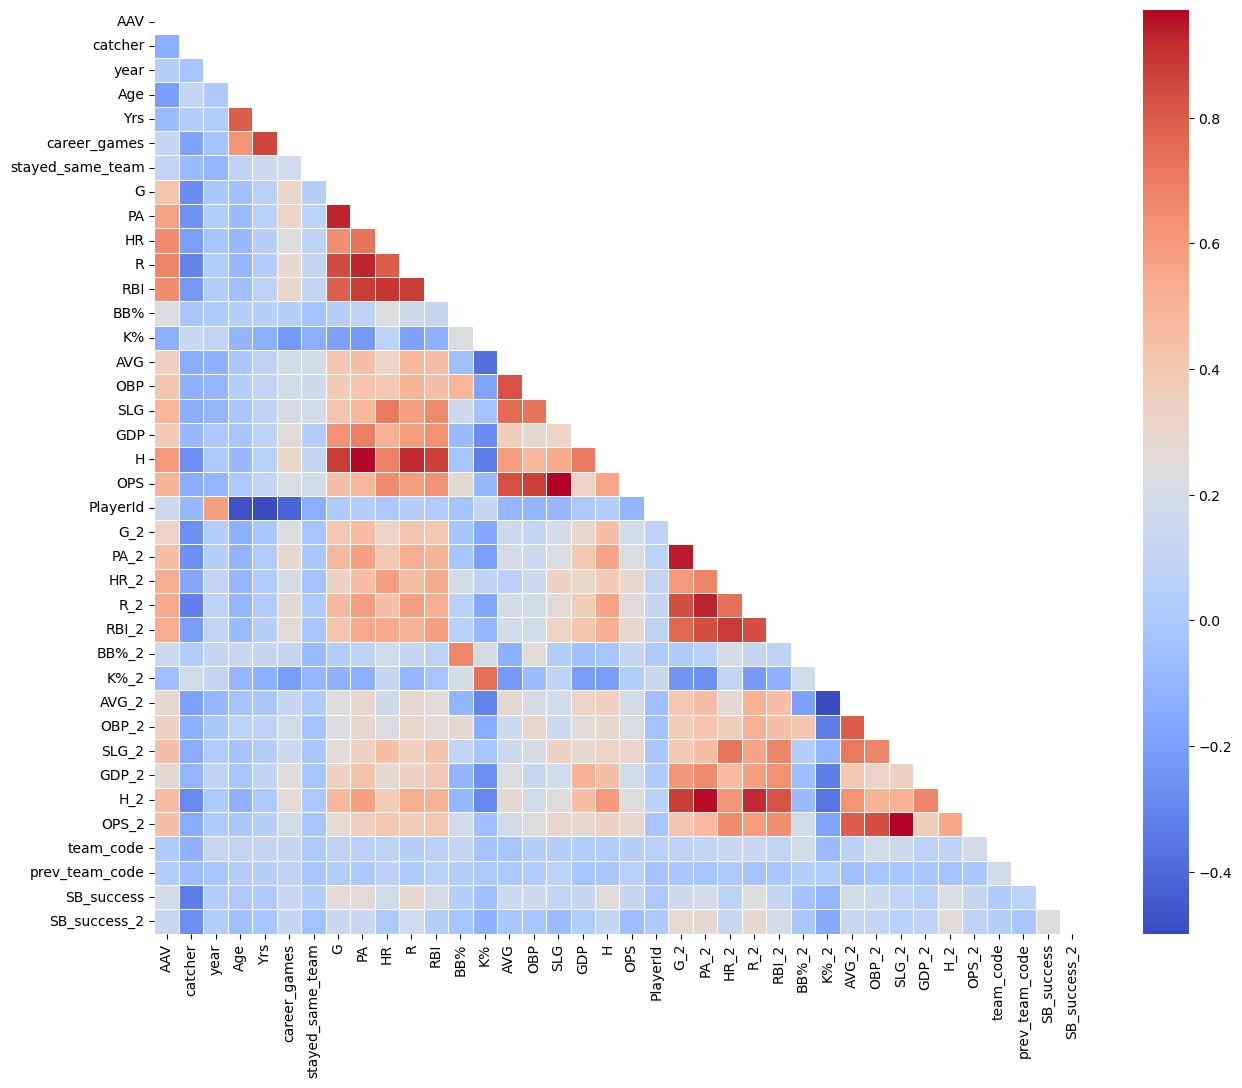

In [25]:
corr_matrix = df4.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 12))


sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=ax)

plt.show()

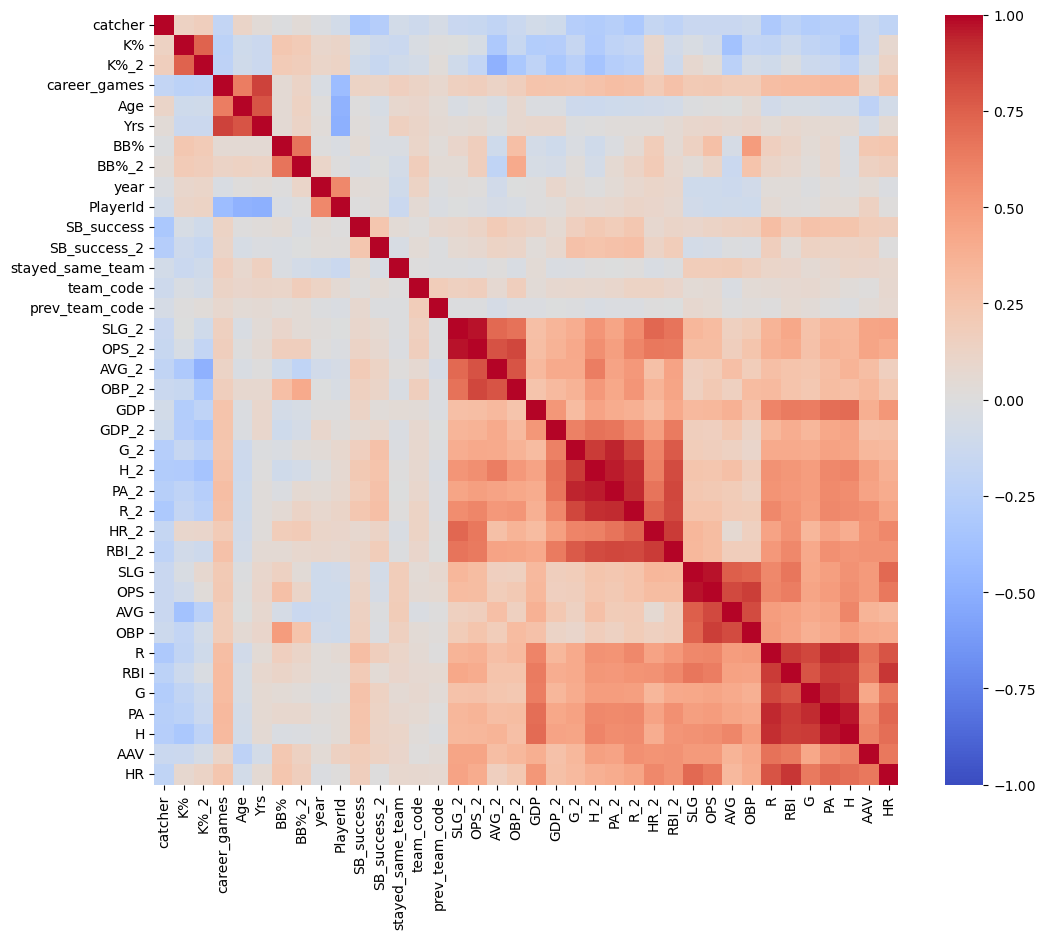

In [26]:
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(corr_matrix, method='ward')

dendro = dendrogram(linked, no_plot=True)
reordered_corr_matrix = corr_matrix.iloc[dendro['leaves'], dendro['leaves']]

plt.figure(figsize=(12, 10))

sns.heatmap(reordered_corr_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)

plt.savefig('corr_matrix_clustered.png')

plt.show()

We can see K% in both years doesn't have a significant correlation with AAV. 

The same goes for BB%. BB%'s correlation is higher, but it is very highly correlated with OBP, and that makes sense as both are calculation for essentialy the same thing. OBP has a much higher correlation with AAV, so dropping BB% for both years wont impact our model. 

Our created variable 'Catcher' seems to have a very small correlation to AAV, but higher with some others. I chose to keep it.

I can't say the same thing for 'stayed_same_team'. Players seem to have accepted a very slight paycut when staying in the same team. This can be attributed, as pointed out by Libsch (2018) to players familiarity with the city, and an already established position. Basically they gave up very little money for comfort. I chose to keep it in the mean time. 

CS AND SB will be kept for now. 

Finally, from Yrs / career_games / Age, the one that shows a bigger correlation with AAV is age. It doesn't make sense to keep all three, just AGE. 

In [25]:
columns_to_drop = ['BB%', 'BB%_2', 'Yrs', 'career_games', 'K%', 'K%_2', 'team_code', 'prev_team_code']

df5 = df4.drop(columns=columns_to_drop)

df5.head()

,Name,AAV,catcher,year,Age,stayed_same_team,G,PA,HR,R,...,R_2,RBI_2,AVG_2,OBP_2,SLG_2,GDP_2,H_2,OPS_2,SB_success,SB_success_2
0,Shohei Ohtani,35.122807,0,2024,29,0,135,599,44,102,...,90,95,0.273038,0.355856,0.518771,6,160,0.874627,76.923077,55.000000
1,Aaron Judge,39.769293,0,2023,31,1,157,696,62,133,...,89,98,0.287273,0.372828,0.543636,16,158,0.916464,84.210526,85.714286
2,Carlos Correa,38.509351,0,2022,27,0,148,640,26,104,...,42,59,0.278571,0.358255,0.567857,8,78,0.926113,0.000000,100.000000
3,Anthony Rendon,41.567039,0,2020,30,0,146,646,34,117,...,88,92,0.308129,0.373534,0.534972,5,163,0.908506,83.333333,66.666667
4,Carlos Correa,33.141078,0,2023,28,1,136,590,22,70,...,104,92,0.279279,0.365625,0.484685,16,155,0.850310,0.000000,0.000000


In [26]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 642
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              421 non-null    object 
 1   AAV               421 non-null    float64
 2   catcher           421 non-null    int64  
 3   year              421 non-null    int64  
 4   Age               421 non-null    int64  
 5   stayed_same_team  421 non-null    int64  
 6   G                 421 non-null    int64  
 7   PA                421 non-null    int64  
 8   HR                421 non-null    int64  
 9   R                 421 non-null    int64  
 10  RBI               421 non-null    int64  
 11  AVG               421 non-null    float64
 12  OBP               421 non-null    float64
 13  SLG               421 non-null    float64
 14  GDP               421 non-null    int64  
 15  H                 421 non-null    int64  
 16  OPS               421 non-null    float64
 1

In [27]:
boolean_columns = ['catcher', 'stayed_same_team']
df5[boolean_columns] = df5[boolean_columns].astype(bool)

In [28]:
df5.to_csv('df5.csv', index=False)

I will select all of the features in our updated df except the target and PlayerId

In [29]:
target = "AAV"
features = [col for col in df5.columns if col != target and col != "PlayerId" and col!= "Name" and col!= "year"]
X, y = df5[features], df5[target]

## Train-Test split

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (336, 27)
X_test shape: (85, 27)
y_train shape: (336,)
y_test shape: (85,)


#### Distribution of y_train values

C:\Users\mfran\AppData\Local\Temp\ipykernel_12040\3840007699.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train, shade=True)


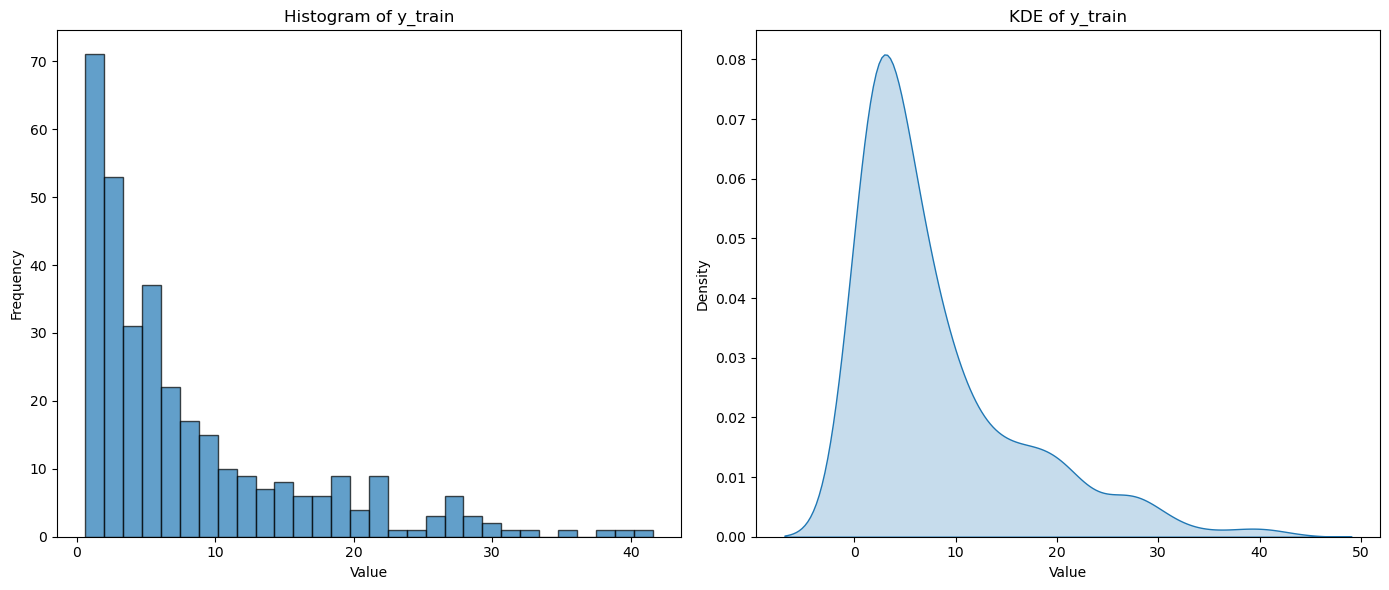

In [31]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_train, shade=True)
plt.title('KDE of y_train')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### Distribution of test values

C:\Users\mfran\AppData\Local\Temp\ipykernel_12040\893388450.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, shade=True)


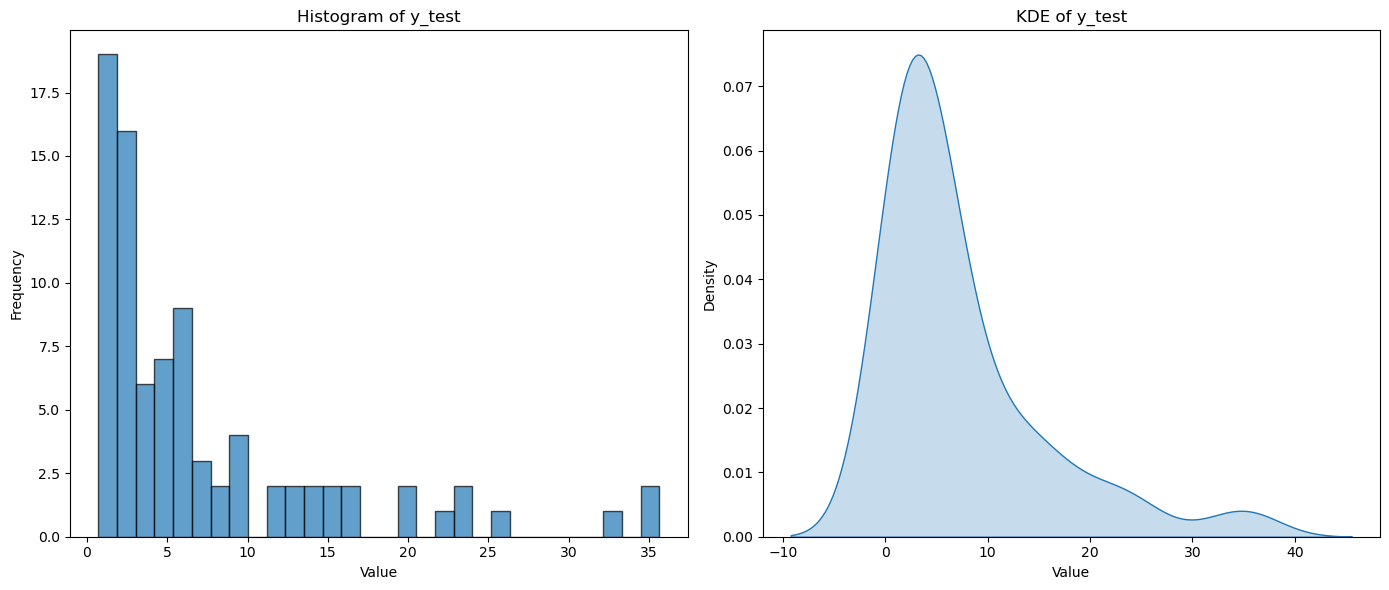

In [32]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_test, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_test, shade=True)
plt.title('KDE of y_test')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

## Linear Model

In [33]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [34]:
linear_model.coef_, linear_model.intercept_

(array([ 3.05800415e+00, -3.65296306e-01,  4.70797305e-01, -3.32422697e-02,
        -5.77879683e-02,  2.31230552e-01,  1.93651036e-01,  3.73574782e-02,
        -3.91309014e+01, -1.86339374e+03, -1.92324178e+03, -1.03403141e-02,
         1.76398377e-01,  1.90973297e+03, -4.98213905e-02,  7.96968882e-03,
         2.39397648e-02,  8.40457167e-02,  4.00519597e-02, -3.25730303e+00,
        -5.63972605e+02, -5.73201837e+02, -6.18714413e-02, -2.31882675e-02,
         5.74593098e+02,  8.61244789e-03,  1.04385373e-02]),
 10.289727948867228)

In [35]:
linear_y_pred = linear_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,catcher,Age,stayed_same_team,G,PA,HR,R,RBI,AVG,OBP,...,SLG_2,GDP_2,H_2,OPS_2,SB_success,SB_success_2,y_real,y_pred,err,%_err
433,False,31,True,84,221,9,34,33,0.241379,0.298643,...,0.344595,7,73,0.623591,75.000000,100.000000,1.187630,5.108691,-3.921061,-330.158574
165,False,36,False,134,495,12,74,48,0.248899,0.305668,...,0.439883,5,88,0.746116,87.755102,69.230769,7.026613,7.542155,-0.515543,-7.337000
17,False,31,False,160,678,26,70,93,0.257600,0.305310,...,0.490982,18,133,0.806870,77.777778,66.666667,23.500000,11.759854,11.740146,49.958069
179,False,32,False,117,436,6,43,39,0.251269,0.314943,...,0.406375,16,128,0.732539,100.000000,0.000000,6.240850,1.998475,4.242375,67.977515
4,False,28,True,136,590,22,70,64,0.291188,0.366102,...,0.484685,16,155,0.850310,0.000000,0.000000,33.141078,18.670919,14.470159,43.662306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,False,35,False,92,353,21,45,58,0.246875,0.303116,...,0.400697,2,61,0.676887,100.000000,0.000000,3.000000,6.282625,-3.282625,-109.420818
90,False,31,True,118,453,13,45,53,0.231144,0.297778,...,0.409195,5,111,0.723541,78.260870,65.384615,13.467674,6.519885,6.947789,51.588632
341,False,35,True,52,190,6,20,27,0.257310,0.321053,...,0.486111,10,76,0.823572,0.000000,50.000000,2.375259,3.464122,-1.088863,-45.841846
81,False,31,True,159,667,47,94,108,0.256117,0.316342,...,0.448819,12,133,0.758911,100.000000,0.000000,14.638776,19.361805,-4.723029,-32.263821


### Evaluation Metrics 

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 4.99165973244858
MAPE: 1.0629577869033862
R^2: 0.6093782365060826


The RMSE is telling us the average error in the predictions: we are failing by 4.99 on average. The MAPE tells us about the average percentage error, since 5M is not the same in a player's AAV of 200k than for a 40M player AAV : in our case we are failing by 106% on average. Finally the R^2 score is the Pearson's coefficient of predictions against reality: 1 would be a perfect model, while 0 is the worst possible scenario. 

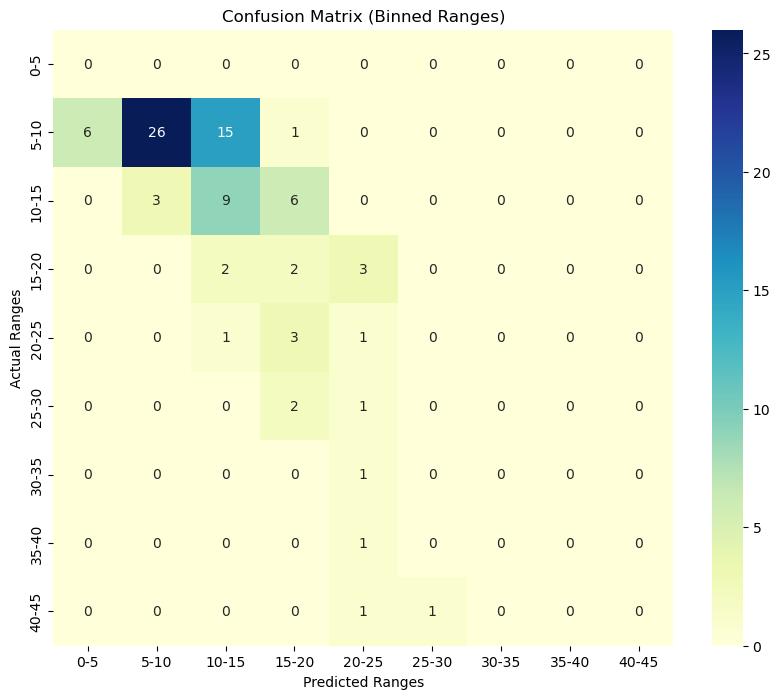

In [37]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
linear_y_pred_binned = bin_values(linear_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, linear_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

#### Correction for negative predictions (Linear Regression)

In [38]:
negative_values_exist = (results_df["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


If our target variable (AAV) is strictly positive, we might transform the target variable before training the model and then inverse transform the predictions. A common transformation for strictly positive data is the logarithm.

Step-by-Step Implementation

    Log Transformation: 
        We apply a logarithmic transformation to the target variable (y_train). This maps the target values from the positive domain to the real number domain, where the regression model can better capture the relationships without producing negative predictions.

    Training the Model: 
        Train the regression model using the transformed target variable.

    Prediction: 
        Make predictions using the trained model on the test set.

    Inverse Transformation: 
        Apply the exponential function to the predicted values to transform them back to the original scale.

In [39]:
linear_model = LinearRegression()

y_train_log = np.log(y_train)
linear_model.fit(X_train, y_train_log)

linear_y_pred_log = linear_model.predict(X_test)


linear_y_pred = np.exp(linear_y_pred_log)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,catcher,Age,stayed_same_team,G,PA,HR,R,RBI,AVG,OBP,...,SLG_2,GDP_2,H_2,OPS_2,SB_success,SB_success_2,y_real,y_pred,err,%_err
433,False,31,True,84,221,9,34,33,0.241379,0.298643,...,0.344595,7,73,0.623591,75.000000,100.000000,1.187630,3.149521,-1.961891,-165.193848
165,False,36,False,134,495,12,74,48,0.248899,0.305668,...,0.439883,5,88,0.746116,87.755102,69.230769,7.026613,5.208864,1.817749,25.869492
17,False,31,False,160,678,26,70,93,0.257600,0.305310,...,0.490982,18,133,0.806870,77.777778,66.666667,23.500000,11.238764,12.261236,52.175473
179,False,32,False,117,436,6,43,39,0.251269,0.314943,...,0.406375,16,128,0.732539,100.000000,0.000000,6.240850,3.051187,3.189663,51.109434
4,False,28,True,136,590,22,70,64,0.291188,0.366102,...,0.484685,16,155,0.850310,0.000000,0.000000,33.141078,16.629871,16.511207,49.820971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,False,35,False,92,353,21,45,58,0.246875,0.303116,...,0.400697,2,61,0.676887,100.000000,0.000000,3.000000,4.948221,-1.948221,-64.940709
90,False,31,True,118,453,13,45,53,0.231144,0.297778,...,0.409195,5,111,0.723541,78.260870,65.384615,13.467674,4.485197,8.982477,66.696572
341,False,35,True,52,190,6,20,27,0.257310,0.321053,...,0.486111,10,76,0.823572,0.000000,50.000000,2.375259,2.431277,-0.056018,-2.358380
81,False,31,True,159,667,47,94,108,0.256117,0.316342,...,0.448819,12,133,0.758911,100.000000,0.000000,14.638776,16.127825,-1.489048,-10.171944


In [40]:
print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 5.071861221515476
MAPE: 0.5519478669020704
R^2: 0.5967250800767756


The model improves drastically in terms of average deviation (MAPE). It went from predicting with an error of 100% on average, to 50%. 

### Evaluating per ranges

#### Testing 0-5 range values

In [41]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df['y_real_in_range'] = results_df['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df['in_range'] = results_df.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df['y_real_in_range'].sum()

correct_predictions = results_df['in_range'].sum()

print(f'Number of y_real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of y_real values in the range 0-5: 48
Number of correct predictions in the range 0-5: 44


#### All ranges visualized with a bar plot


   Range  Total Real in range  Correct Predictions
0    0-5                   48                   44
1   5-10                   18                    8
2  10-15                    8                    0
3  15-20                    5                    0
4  20-25                    3                    0
5  25-30                    1                    0
6  30-35                    1                    0
7  35-40                    2                    0
8    40+                    0                    0


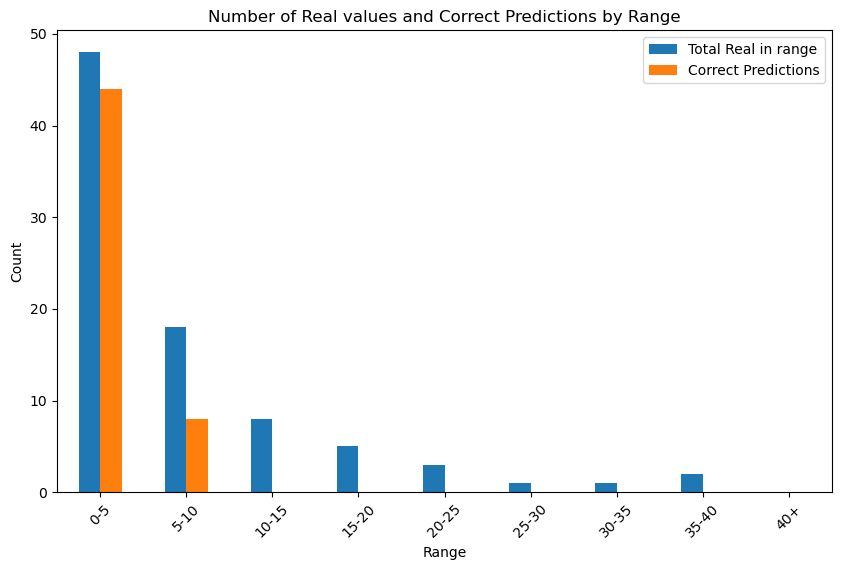

In [42]:
ranges = [ (0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, float('inf'))]

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df['y_real_in_range'] = results_df['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df['in_range'] = results_df.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df['y_real_in_range'].sum()
    
    correct_predictions = results_df['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total Real in range': total_y_real_in_range,
        'Correct Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of Real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

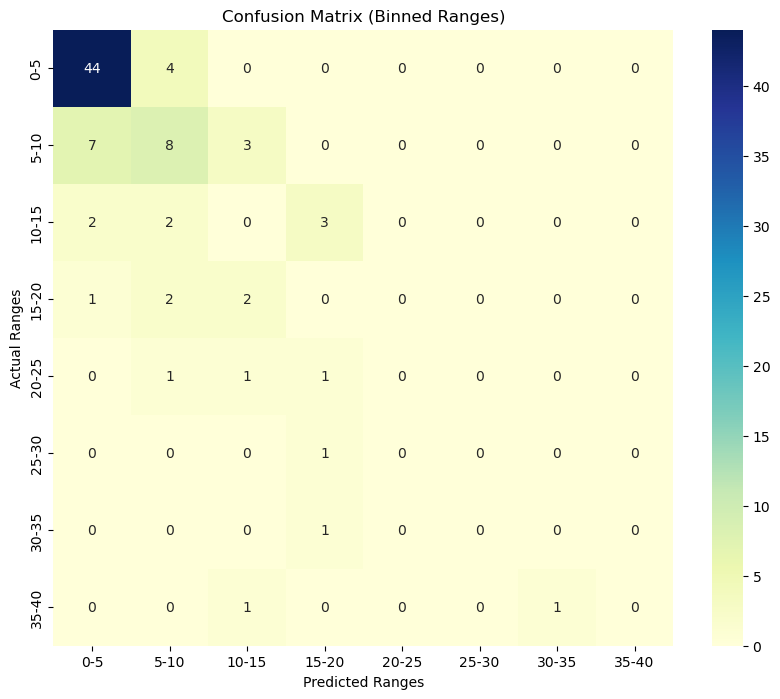

In [43]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
linear_y_pred_binned = bin_values(linear_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, linear_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

## XGBoost

In [44]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

results_df_xgb = X_test.copy()
results_df_xgb["y_real"] = y_test
results_df_xgb["y_pred"] = xgb_y_pred
results_df_xgb["err"] = results_df_xgb["y_real"] - results_df_xgb["y_pred"]
results_df_xgb["%_err"] = results_df_xgb["err"] / results_df_xgb["y_real"] * 100


results_df_xgb


,catcher,Age,stayed_same_team,G,PA,HR,R,RBI,AVG,OBP,...,SLG_2,GDP_2,H_2,OPS_2,SB_success,SB_success_2,y_real,y_pred,err,%_err
433,False,31,True,84,221,9,34,33,0.241379,0.298643,...,0.344595,7,73,0.623591,75.000000,100.000000,1.187630,5.068576,-3.880946,-326.780836
165,False,36,False,134,495,12,74,48,0.248899,0.305668,...,0.439883,5,88,0.746116,87.755102,69.230769,7.026613,4.177799,2.848814,40.543204
17,False,31,False,160,678,26,70,93,0.257600,0.305310,...,0.490982,18,133,0.806870,77.777778,66.666667,23.500000,10.417968,13.082032,55.668222
179,False,32,False,117,436,6,43,39,0.251269,0.314943,...,0.406375,16,128,0.732539,100.000000,0.000000,6.240850,3.726444,2.514406,40.289484
4,False,28,True,136,590,22,70,64,0.291188,0.366102,...,0.484685,16,155,0.850310,0.000000,0.000000,33.141078,23.250469,9.890608,29.843955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,False,35,False,92,353,21,45,58,0.246875,0.303116,...,0.400697,2,61,0.676887,100.000000,0.000000,3.000000,5.420761,-2.420761,-80.692037
90,False,31,True,118,453,13,45,53,0.231144,0.297778,...,0.409195,5,111,0.723541,78.260870,65.384615,13.467674,4.039258,9.428417,70.007758
341,False,35,True,52,190,6,20,27,0.257310,0.321053,...,0.486111,10,76,0.823572,0.000000,50.000000,2.375259,3.827642,-1.452383,-61.146285
81,False,31,True,159,667,47,94,108,0.256117,0.316342,...,0.448819,12,133,0.758911,100.000000,0.000000,14.638776,25.238708,-10.599932,-72.409959


In [45]:
print(f"RMSE: {mean_squared_error(y_test, xgb_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, xgb_y_pred)}")
print(f"R^2: {r2_score(y_test, xgb_y_pred)}")

RMSE: 5.735442889739409
MAPE: 0.8723019968309795
R^2: 0.48429610731775363


The XGBoost model performed better in terms of the average deviation (MAPE), but it was still missing by almost 100% every time. The RMSE rose to 5.18 from 4.63 on average in the LM. The MAPE, like I said, decreased slightly from 106% to 92% on average. And R^2 score dropped by 10 percent. 

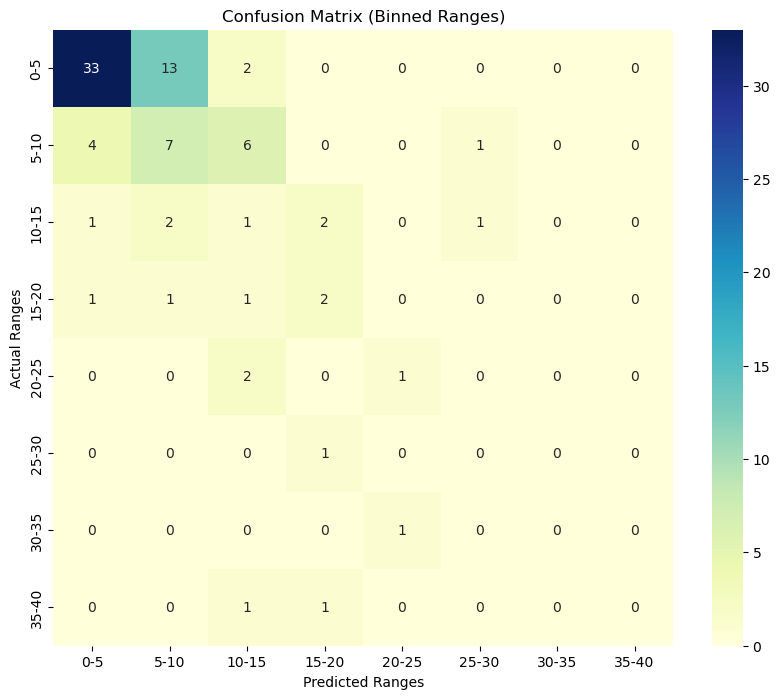

In [46]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
xgb_y_pred_binned = bin_values(xgb_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, xgb_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

#### Correction for negative predictions (XGBoost Regression)

In [47]:
negative_values_exist = (results_df_xgb["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are no negative values in the 'y_pred' column.


## Ridge Regression

In [48]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

ridge_model.fit(X_train, y_train)

ridge_y_pred = ridge_model.predict(X_test)

results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

,catcher,Age,stayed_same_team,G,PA,HR,R,RBI,AVG,OBP,...,SLG_2,GDP_2,H_2,OPS_2,SB_success,SB_success_2,y_real,y_pred,err,%_err
433,False,31,True,84,221,9,34,33,0.241379,0.298643,...,0.344595,7,73,0.623591,75.000000,100.000000,1.187630,6.025632,-4.838003,-407.366260
165,False,36,False,134,495,12,74,48,0.248899,0.305668,...,0.439883,5,88,0.746116,87.755102,69.230769,7.026613,9.104623,-2.078010,-29.573423
17,False,31,False,160,678,26,70,93,0.257600,0.305310,...,0.490982,18,133,0.806870,77.777778,66.666667,23.500000,11.994375,11.505625,48.960107
179,False,32,False,117,436,6,43,39,0.251269,0.314943,...,0.406375,16,128,0.732539,100.000000,0.000000,6.240850,1.944927,4.295923,68.835546
4,False,28,True,136,590,22,70,64,0.291188,0.366102,...,0.484685,16,155,0.850310,0.000000,0.000000,33.141078,17.663821,15.477257,46.701128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,False,35,False,92,353,21,45,58,0.246875,0.303116,...,0.400697,2,61,0.676887,100.000000,0.000000,3.000000,8.182982,-5.182982,-172.766070
90,False,31,True,118,453,13,45,53,0.231144,0.297778,...,0.409195,5,111,0.723541,78.260870,65.384615,13.467674,6.675891,6.791784,50.430264
341,False,35,True,52,190,6,20,27,0.257310,0.321053,...,0.486111,10,76,0.823572,0.000000,50.000000,2.375259,3.805664,-1.430404,-60.220978
81,False,31,True,159,667,47,94,108,0.256117,0.316342,...,0.448819,12,133,0.758911,100.000000,0.000000,14.638776,19.226916,-4.588140,-31.342371


In [49]:
print(f"RMSE: {mean_squared_error(y_test, ridge_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, ridge_y_pred)}")
print(f"R^2: {r2_score(y_test, ridge_y_pred)}")

RMSE: 5.164061261327917
MAPE: 1.009367685839238
R^2: 0.5819297524310248


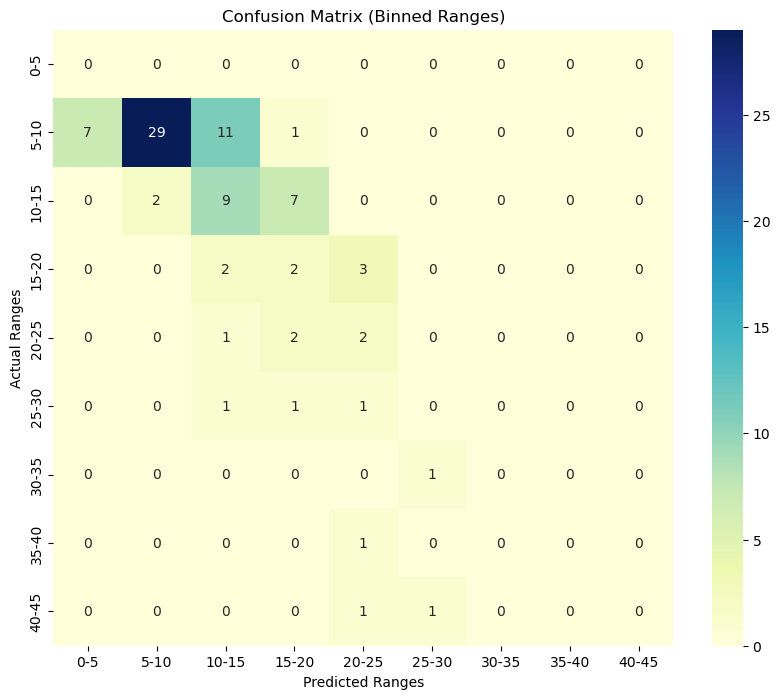

In [50]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
ridge_y_pred_binned = bin_values(ridge_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, ridge_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

##### Correction for negative predictions 

In [51]:
negative_values_exist = (results_df_ridge["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [52]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


y_train_log = np.log(y_train)


ridge_model = Ridge()
ridge_model.fit(X_train, y_train_log)


ridge_y_pred_log = ridge_model.predict(X_test)


ridge_y_pred = np.exp(ridge_y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
r2 = r2_score(y_test, ridge_y_pred)
mape = np.mean(np.abs((y_test - ridge_y_pred) / y_test)) 

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R^2: {r2}")


results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge


RMSE: 5.149329915192405
MAPE: 0.570006774467439
R^2: 0.5843115805316729


,catcher,Age,stayed_same_team,G,PA,HR,R,RBI,AVG,OBP,...,SLG_2,GDP_2,H_2,OPS_2,SB_success,SB_success_2,y_real,y_pred,err,%_err
433,False,31,True,84,221,9,34,33,0.241379,0.298643,...,0.344595,7,73,0.623591,75.000000,100.000000,1.187630,2.991279,-1.803649,-151.869657
165,False,36,False,134,495,12,74,48,0.248899,0.305668,...,0.439883,5,88,0.746116,87.755102,69.230769,7.026613,5.567868,1.458745,20.760285
17,False,31,False,160,678,26,70,93,0.257600,0.305310,...,0.490982,18,133,0.806870,77.777778,66.666667,23.500000,11.748572,11.751428,50.006077
179,False,32,False,117,436,6,43,39,0.251269,0.314943,...,0.406375,16,128,0.732539,100.000000,0.000000,6.240850,2.944270,3.296579,52.822607
4,False,28,True,136,590,22,70,64,0.291188,0.366102,...,0.484685,16,155,0.850310,0.000000,0.000000,33.141078,16.786105,16.354972,49.349549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,False,35,False,92,353,21,45,58,0.246875,0.303116,...,0.400697,2,61,0.676887,100.000000,0.000000,3.000000,4.977915,-1.977915,-65.930488
90,False,31,True,118,453,13,45,53,0.231144,0.297778,...,0.409195,5,111,0.723541,78.260870,65.384615,13.467674,4.446056,9.021618,66.987201
341,False,35,True,52,190,6,20,27,0.257310,0.321053,...,0.486111,10,76,0.823572,0.000000,50.000000,2.375259,2.515720,-0.140460,-5.913478
81,False,31,True,159,667,47,94,108,0.256117,0.316342,...,0.448819,12,133,0.758911,100.000000,0.000000,14.638776,18.054924,-3.416147,-23.336289


#### Testing 0-5 range values

In [53]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_ridge['y_real_in_range'] = results_df_ridge['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_ridge['in_range'] = results_df_ridge.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_ridge['y_real_in_range'].sum()

correct_predictions = results_df_ridge['in_range'].sum()

print(f'Number of Real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of Real values in the range 0-5: 48
Number of correct predictions in the range 0-5: 45


#### All ranges visualized with a bar plot

   Range  Total Real in range  Correct Predictions
0    0-5                   48                   45
1   5-10                   18                    7
2  10-15                    8                    0
3  15-20                    5                    0
4  20-25                    3                    0
5  25-30                    1                    0
6  30-35                    1                    0
7  35-40                    2                    0
8    40+                    0                    0


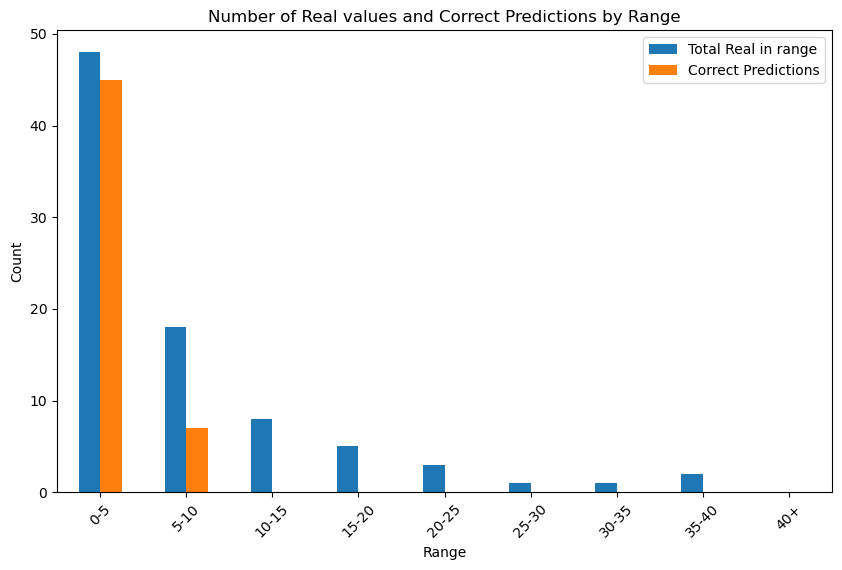

In [54]:
def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df_ridge['y_real_in_range'] = results_df_ridge['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df_ridge['in_range'] = results_df_ridge.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df_ridge['y_real_in_range'].sum()
    
    correct_predictions = results_df_ridge['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total Real in range': total_y_real_in_range,
        'Correct Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of Real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

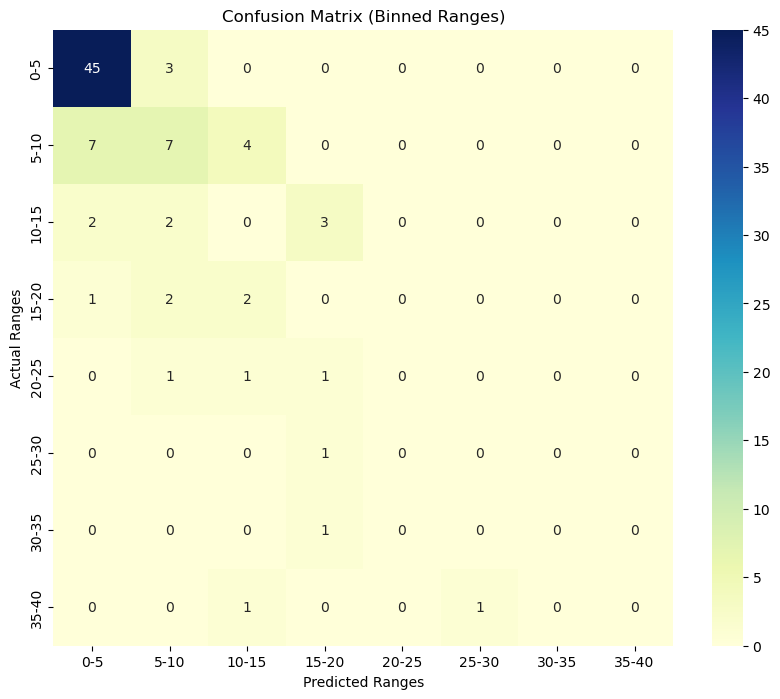

In [55]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
ridge_y_pred_binned = bin_values(ridge_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, ridge_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

#### Min Max Scale for Ridge Regression

In [56]:
y_train_log = np.log(y_train)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train_log)

ridge_y_pred_log = ridge_model.predict(X_test_scaled)

ridge_y_pred = np.exp(ridge_y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
r2 = r2_score(y_test, ridge_y_pred)
mape = np.mean(np.abs((y_test - ridge_y_pred) / y_test))

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R^2: {r2}")

results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge


RMSE: 5.413416686104547
MAPE: 0.5992425927772587
R^2: 0.5405805211872755


,catcher,Age,stayed_same_team,G,PA,HR,R,RBI,AVG,OBP,...,SLG_2,GDP_2,H_2,OPS_2,SB_success,SB_success_2,y_real,y_pred,err,%_err
433,False,31,True,84,221,9,34,33,0.241379,0.298643,...,0.344595,7,73,0.623591,75.000000,100.000000,1.187630,3.053826,-1.866197,-157.136250
165,False,36,False,134,495,12,74,48,0.248899,0.305668,...,0.439883,5,88,0.746116,87.755102,69.230769,7.026613,5.140659,1.885953,26.840149
17,False,31,False,160,678,26,70,93,0.257600,0.305310,...,0.490982,18,133,0.806870,77.777778,66.666667,23.500000,11.853843,11.646157,49.558116
179,False,32,False,117,436,6,43,39,0.251269,0.314943,...,0.406375,16,128,0.732539,100.000000,0.000000,6.240850,3.259016,2.981834,47.779287
4,False,28,True,136,590,22,70,64,0.291188,0.366102,...,0.484685,16,155,0.850310,0.000000,0.000000,33.141078,13.240439,19.900638,60.048254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,False,35,False,92,353,21,45,58,0.246875,0.303116,...,0.400697,2,61,0.676887,100.000000,0.000000,3.000000,4.664656,-1.664656,-55.488529
90,False,31,True,118,453,13,45,53,0.231144,0.297778,...,0.409195,5,111,0.723541,78.260870,65.384615,13.467674,4.761826,8.705848,64.642548
341,False,35,True,52,190,6,20,27,0.257310,0.321053,...,0.486111,10,76,0.823572,0.000000,50.000000,2.375259,2.576606,-0.201347,-8.476838
81,False,31,True,159,667,47,94,108,0.256117,0.316342,...,0.448819,12,133,0.758911,100.000000,0.000000,14.638776,16.852901,-2.214125,-15.125068


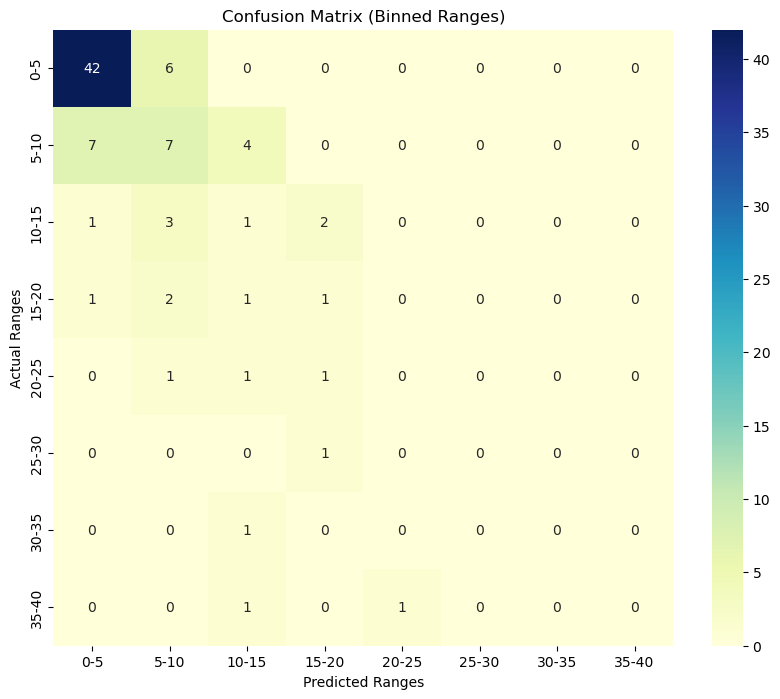

In [57]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
ridge_y_pred_binned = bin_values(ridge_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, ridge_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()